# Lab: Linear Models and Regularization Methods

Let's import some stuff.

In [35]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
    (Stepwise ,
    sklearn_selected ,
    sklearn_selection_path )
from l0bnb import fit_path

# Subset Selection Methods

Here we implement methods that reduce the number of parameters in a model by restricting the model to a subset of the input variables.

## Forward Selection

We will apply the forward-selection approach to the `Hitters` data. We wish to predict a baseball player's `Salary` on the basis of various statistics associated with performance in the previous year.

First of all, we note that the `Salary` variable is missing for some players. The `np.isnan()` function can be used to identify the missing observations. It returns an array of the same shape as the input vector, with a `True` for any elements that are missing, and a `False` for non-missing elements.

In [36]:
Hitters = load_data('Hitters')
np.isnan(Hitters["Salary"]).sum()
Hitters.shape

(322, 20)

We see that `Salary` is missing for 59 players. The `dropna()` method of data frames removes all of the rows that have missing values in any variable.

In [37]:
Hitters = Hitters.dropna(); # `;` suppresses the output of the given line
Hitters.shape

(263, 20)

We first choose the best model using forward selection based on Cp

**Note:** Cp is part of the Cp, AIC, BIC, and Adjusted R2 options for estimating the test MSE. We create a test MSE because any sort of interaction with the actual test set would potentially cause overfitting for the model.

This score is not built in as a metric to `sklearn`. We therefore define a function to compute it ourselves, and use it as a scorer. By default, `sklearn` tries to maximize a score, hence our scoring function computes the negative Cp statistic.

In [38]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

We need to estimate the residual variance `std**2`, which is the first argument in our scoring function above. We will fit the biggest model using all the variables, and estimate `std**2` based on its MSE.

In [39]:
design = MS(Hitters.columns.drop("Salary")).fit(Hitters)
Y = np.array(Hitters["Salary"])
X = design.transform(Hitters)
sigma2 = OLS(Y, X).fit().scale

The function `sklearn_selected()` expects a scorer with just three arguments-the last three in the definition of `nCp()` above. We use the function `partial()` to freeze the first argument with our estimate of `std**2`.

In [40]:
neg_Cp = partial(nCp, sigma2)

We can now use the `neg_Cp()` as a scorer for model selection.

Along with a score we need to specify the search strategy. This is done through the objecrt `Stepwise()` in the `ISLP.models` package. The method `Stepwise.first_peak()` runs forward stepwise until any further additions to the model do not result in an improvement in the evaluation score.

Similarly, the method `Stepwise.fixed_steps()` runs a fixed number of steps of stepwise search.

In [41]:
strategy = Stepwise.first_peak(design,
                               direction="forward",
                               max_terms=len(design.terms))

We now fit a linear regression model with `Salary` as outcome using forward selection. To do so, we use the function `sklearn_selected()` from the `ISLP.models` package. This takes a model from `statsmodels` along with a search strategy and selects a model with its `fit` method. Without specifying a `scoring` argument, the score defaults to MSE, and so all 19 variables will be selected.

In [42]:
hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

Using `nug_Cp` results in a smaller model, as expected, with just 10 variables selected.

In [43]:
hitters_Cp = sklearn_selected(OLS,
                              strategy,
                              scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

## Choosing Among Models Using the Validation Set Approach and Cross-Validation

As an alternative to using Cp, we might try cross-validation to select a model in forward selection. For this, we need a method that stores the full path of models found in forward selection, and allows predictions for each of these.

This can be done with the `sklearn_selection_path()` estimator from `ISLP.models`. The function `cross_val_predict()` from `ISLP.models` computes the cross-validates predictions for each of the models along the path, which we can use to evaluate the cross-validated MSE along the path.

Here we define a strategy that fits the full forward selection path. While there are various parameter choices for `sklearn_selection_path()`, we use the defaults here, which selects the model at each step based on the biggest reduction in RSS.

In [44]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction="forward")
full_path = sklearn_selection_path(OLS, strategy)

We now fit the full forward-selection path on the `Hitters` data and compute the fitted values.

In [45]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

This gives us an array of fitted values with 20 steps in all, including the fitted mean for the null model that we can use to evaluate in-sample MSE. As expected, the in-sample MSE improves each step we take, indicating we must use either the validation or cross-validation approach to select the number of steps. We fix the y-axis to range from 50,000 to 250,000 to compare the cross-validation and validation set MSE below, as well as other methods such as ridge regression, lasso, and principal components regression.

(50000.0, 250000.0)

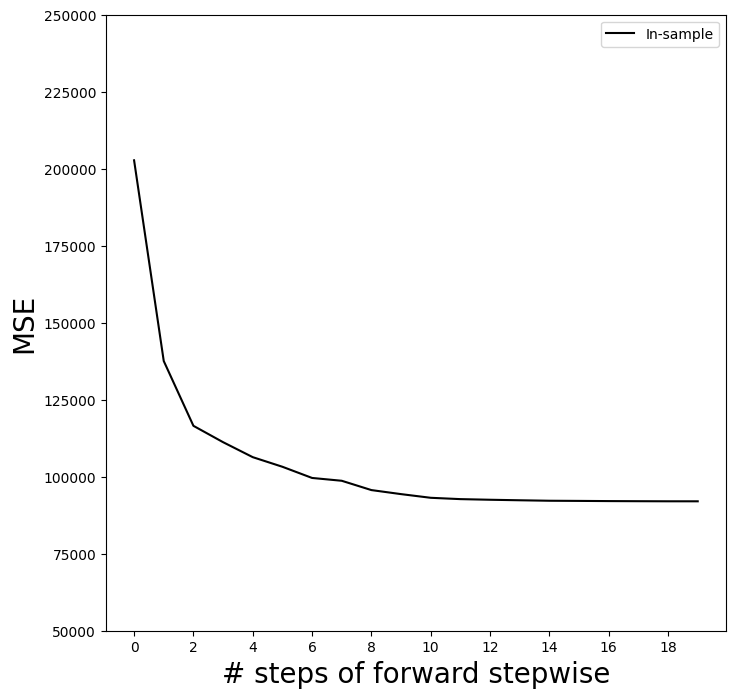

In [46]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[: ,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        "k", # color black
        label="In-sample")
ax.set_ylabel("MSE",
              fontsize=20)
ax.set_xlabel("# steps of forward stepwise",
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000, 250000])

Notice the expression `None` in `Y[:,None]` above. This adds an axis (dimension) to the one-dimensional array `Y`, which allows it to be recycled when subtracted fro the two-dimensional `Yhat_in`.

We are now ready to use cross-validation to estimate test error along the model path. We must use **only the training observations** to perform all aspects of model-fitting - including variable selection. Therefore, the determination of which model of a given size is best must be made using only the training observations in each training fold. This point is subtle but important. If the full data set is used to select the best subset at each step, then the validation set errors and cross-validation errors that we obtain will not be accurate estimates of the test error.

We now compute the cross-validated predicted values using 5-fold cross-validation.

In [47]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                Hitters,
                                Y,
                                cv=kfold)
print(Yhat_in.shape)
Yhat_cv.shape

(263, 20)


(263, 20)

The prediction matrix `Yhat_cv` is the same shape as `Yhat_in`; the difference is that the predictions in each row, corresponding to a particular index, were made from models fit on a training fold that didn't include that row.

At each model along the path, we compute MSE in each of the cross-validation folds. These will average to get the mean MSE, and can also use the individual values to compute a crude estimate of the standard error of the mean. Hence we must know the test indices for each cross-validation split. This 9can be found by using the `split()` method of `kfold`. Because we fixed the random state above, whenever we split any array with the same number of rows as Y we recover the same training and test indices, though we simply ignore the training indices below.

**Note:** The estimate is crude because the five error estimates are based on overlapping training sets, and hence are not independent.

In [ ]:
cv_mse = []

# There's likely a more computationally efficient way to do this with numpy using matrices
for train_idx , test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx ,None]) **2
    cv_mse.append(errors.mean (0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

We now add the cross-validation error estimates to our MSE plot. We include the mean error across the five folds, and the estimate of the standard error of the mean.

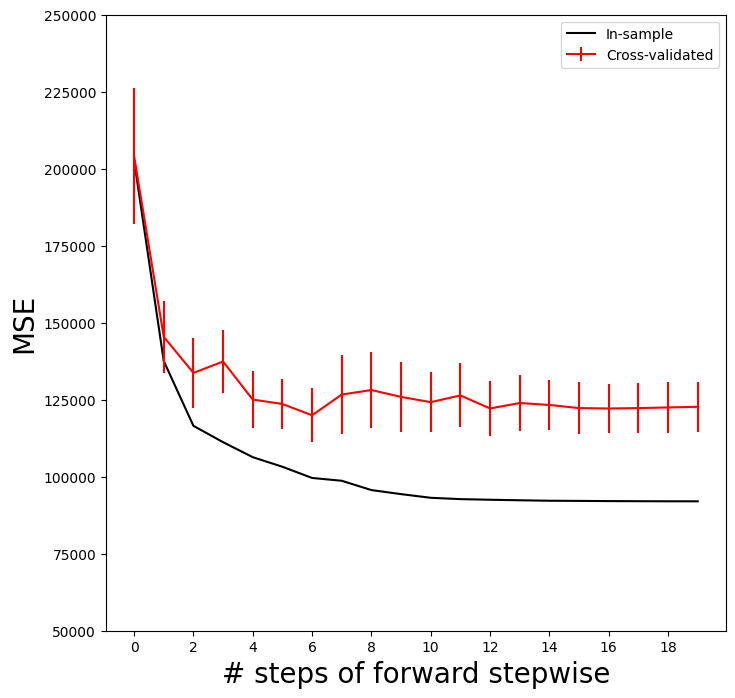

In [54]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label="Cross-validated",
            c="r") # color red

ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

# Best Subset Selection

Forward stepwise is a **greedy** selection procedure; at each step it augments the current set by including one additional variable. We now apply best subset selection to the `Hitters` data, which for every subset size, searches for the best set of predictors. 

We will use a package called `l0bnb` to perform best subset selection. Instead of constraining the subsset to be a given size, this package produces a path of solutions using the subset size as a penalty rather than a constraint. Although the distinction is subtle, the difference comes when we cross-validate.

In [55]:
D = design.fit_transform(Hitters)
D = D.drop("intercept", axis=1)
X = np.asarray(D)

Here we excluded the first column corresponding to the intercept, as `l0bnb` will fit the intercept separately. We can find a path using the `fit_path()` function.

**Turns out that `l0bnb` is outdated and won't work with a newer version of `numpy`. Either way, who cares. Best subset selection is inefficient and pointless anyway.**

# Ridge Regression and the Lasso

We will now use the `sklearn.linear_model` package (finally) to fit ridge and lasso regularized linear models on the `Hitters` data. We start with the model matrix `X` (without an intercept) that we computed in the previous section on best subset regression.

## Ridge Regression

We will use the function `skl.ElasticNet()` to fit both ridge and the lasso. To fit a **path** of ridge regressions models, we use `skl.ElasticNet.path()`, which can fit both ridge and lasso, as well as a hybrid mixture; ridge regression corresponds to `l1_ratio=0`. It's good practice to standardize the columns of `X` in these applications, if the variables are measured in different units.

Since `skl.ElasticNet()` does no normalization, we have to take care of that ourselves. Since we standardize first, in order to find coefficient estimates on the original scale, we must *unstandardize* the coefficient estimates. The parameter λ is called `alphas` in `sklearn`. In order to be consistent with the rest of this chapter, we use `lambdas` instead of `alphas` (no were not).

**Note:** It's best practice to do standardization in-place. We don't want to save the standardized variables to a new variable for the sake of memory efficiency in the case of very large datasets.

In [ ]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:] # Standardize
alphas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas = alphas)

/Users/christiancamp/Desktop/Learning Machine Learning/ml-learning-linear-regression-part-2/lin-reg-env/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/christiancamp/Desktop/Learning Machine Learning/ml-learning-linear-regression-part-2/lin-reg-env/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.443e+07, tolerance: 1.289e+04
  model = cd_fast.enet_coordinate_descent_gram(
/Users/christiancamp/Desktop/Learning Machine Learning/ml-learning-linear-regression-part-2/lin-reg-env/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_desce